In [139]:
import numpy as np
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt
%matplotlib inline
import os
import geopandas as gpd
from mpl_toolkits.mplot3d import Axes3D
from geopy.geocoders import Nominatim
import folium

In [14]:
address = 'Andreas Vesaliusstraat 13 3000 Leuven '
df = gpd.tools.geocode(address)
df

,geometry,address
0,POINT (4.70793 50.87486),"Campus Groep T, 13, Andreas Vesaliusstraat, 30..."


In [54]:
#get the latitude and longitude of the address in "epsg:4326"
geolocator = Nominatim(user_agent="Moke", timeout=2)
location = geolocator.geocode(address)
print(location.latitude, location.longitude)

50.87485515 4.707931288875566


In [55]:
#Locating the address using Folium 
House_location = [location.latitude, location.longitude]
House_map = folium.Map(location = House_location, zoom_start=50)
folium.Marker(House_location, popup="MyPlace").add_to(House_map)
House_map
House_map.save(f"{address}.html")

In [104]:
# convert latitude and longitude of the address to epsg:31370
import pyproj
transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:31370")
House_locB = transformer.transform(House_location[0], House_location[1])

In [128]:
House_locB

(173872.54838429907, 173886.31980094593)

In [34]:
os.listdir('./Data/DSM_Data/')

['DHMVIIDSMRAS1m_k32.tif',
 'DHMVIIDSMRAS1m_k01.tif',
 'DHMVIIDSMRAS1m_k02.tif',
 'DHMVIIDSMRAS1m_k31.tif',
 'DHMVII_vdc_k01']

In [57]:
#file name globbing
import glob
glob.glob('./Data/*.tif', recursive=True)

[]

In [58]:
#listing tiff files in a folder
tiff_files = []
for tiff_file in glob.glob('./Data/**/*.tif', recursive=True):
    tiff_files.append(tiff_file)
tiff_files
# sorting the files
sorted(tiff_files)

['./Data/DSM_Data/DHMVIIDSMRAS1m_k01.tif',
 './Data/DSM_Data/DHMVIIDSMRAS1m_k02.tif',
 './Data/DSM_Data/DHMVIIDSMRAS1m_k31.tif',
 './Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif',
 './Data/DTM_Data/DHMVIIDTMRAS1m_k01.tif',
 './Data/DTM_Data/DHMVIIDTMRAS1m_k02.tif',
 './Data/DTM_Data/DHMVIIDTMRAS1m_k31.tif',
 './Data/DTM_Data/DHMVIIDTMRAS1m_k32.tif']

In [132]:
tiff_bounds = []
for tiff_file in glob.glob('./Data/DSM_Data/*.tif'):
    with rasterio.open(tiff_file) as src:
        print(src.bounds[0])
        # if House_locB[0] >= df.bounds[0]: #& House_locB[0] <= df.bounds[2]:
        # tiff_bounds['name'] = src.name
        # tiff_bounds['bounds'] = src.bounds
        # tiff_bounds.append((src.name, src.bounds))

162000.0
145000.0
162000.0
130000.0


In [129]:
tiff_bounds

[('./Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif',
  BoundingBox(left=162000.0, bottom=158000.0, right=194000.0, top=178000.0)),
 ('./Data/DSM_Data/DHMVIIDSMRAS1m_k01.tif',
  BoundingBox(left=145000.0, bottom=238000.0, right=162000.0, top=247000.0)),
 ('./Data/DSM_Data/DHMVIIDSMRAS1m_k02.tif',
  BoundingBox(left=162000.0, bottom=238000.0, right=194000.0, top=250000.0)),
 ('./Data/DSM_Data/DHMVIIDSMRAS1m_k31.tif',
  BoundingBox(left=130000.0, bottom=158000.0, right=162000.0, top=178000.0))]

In [140]:
def boxContains(rect,pt):
    logic = rect[0] < pt[0] < rect[2] and rect[1] < pt[1] < rect[3]
    return logic

src=rasterio.open('Data/DSM_Data/DHMVIIDSMRAS1m_k32.tif')
rect = src.bounds
print(rect)
pt = (173872.54838429907, 173886.31980094593)
boxContains(rect,pt)

BoundingBox(left=162000.0, bottom=158000.0, right=194000.0, top=178000.0)


True

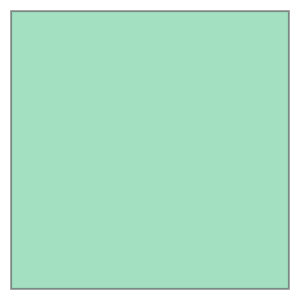

In [145]:
# Using shapely create geometry
from shapely.geometry import Point, LineString, Polygon
import fiona
polygon = Polygon([[pt[0]-250, pt[1]-250], [pt[0]+250, pt[1]-250], [pt[0]+250, pt[1]+250], [pt[0]-250, pt[1]+250]])
# point1 = Point([pt[0]-250, pt[1]-250])
# point2 = Point([pt[0], pt[1]-250])
# point3 = Point([pt[0]+250, pt[1]+250])
# point4 = Point([pt[0]-250, pt[1]+250])

polygon

In [147]:
#Save the geometry in to shapefile
import pickle

# Save polygon 
with open('./AOI', "wb") as poly_file:
    pickle.dump(polygon, poly_file, pickle.HIGHEST_PROTOCOL)

# Load polygon from disc
with open('./AOI', "rb") as poly_file:
    loaded_polygon = pickle.load(poly_file)

# Check it out 
print('My area of interest: \n', loaded_polygon)

My area of interest: 
 POLYGON ((173622.5483842991 173636.3198009459, 174122.5483842991 173636.3198009459, 174122.5483842991 174136.3198009459, 173622.5483842991 174136.3198009459, 173622.5483842991 173636.3198009459))


In [156]:
from bs4 import BeautifulSoup
import requests 
def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']]
    return info['polygon'][0]['coordinates'][0] 

get_coordinates(address)


'polygon'